IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

LOAD DATA

In [2]:
df = pd.read_csv('data/CreditCardFraudFourYears.csv', index_col=0)

GROUP DATA

In [3]:
daily_fraud_trans = df.groupby('trans_date').size()
daily_fraud_trans = df[df['is_fraud'] == 1].groupby('trans_date').size()
daily_fraud_trans.index = pd.to_datetime(daily_fraud_trans.index)
daily_fraud_trans = daily_fraud_trans.rename('daily_fraud')
daily_fraud_trans.head()
                                               

trans_date
2018-01-05     7
2018-01-06    28
2018-01-07    14
2018-01-09     5
2018-01-10     4
Name: daily_fraud, dtype: int64

In [4]:
daily_fraud_trans = daily_fraud_trans.reset_index()
daily_fraud_trans.head()

,trans_date,daily_fraud
0,2018-01-05,7
1,2018-01-06,28
2,2018-01-07,14
3,2018-01-09,5
4,2018-01-10,4


ADDING EXTRA FEATURE: DAY OF THE WEEK

In [5]:
daily_fraud_trans['trans_date'] = pd.to_datetime(daily_fraud_trans['trans_date'])
daily_fraud_trans['day'] = daily_fraud_trans['trans_date'].dt.day
daily_fraud_trans.head(10)

,trans_date,daily_fraud,day
0,2018-01-05,7,5
1,2018-01-06,28,6
2,2018-01-07,14,7
3,2018-01-09,5,9
4,2018-01-10,4,10
5,2018-01-11,5,11
6,2018-01-12,2,12
7,2018-01-13,3,13
8,2018-01-14,3,14
9,2018-01-16,4,16


PLOT DATA

<Axes: xlabel='trans_date', ylabel='daily_fraud'>

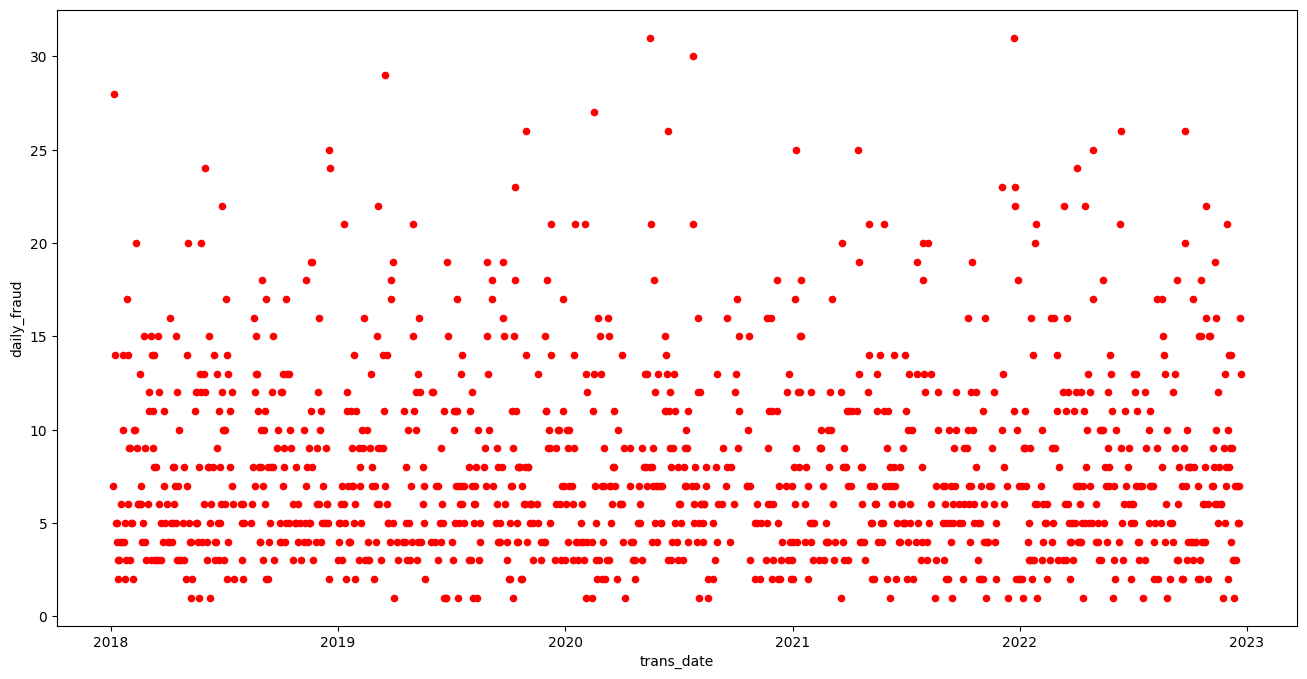

In [6]:
daily_fraud_trans.plot.scatter(x='trans_date', y='daily_fraud', figsize=(16,8), color='red')

## Split Data

In [82]:
df = daily_fraud_trans.copy()
df.head()

,trans_date,daily_fraud,day
0,2018-01-05,7,5
1,2018-01-06,28,6
2,2018-01-07,14,7
3,2018-01-09,5,9
4,2018-01-10,4,10


In [40]:
len(df)

1189

In [85]:
train = df.iloc[:1189-30]
test = df.iloc[1189-30:]


## Scale Data

In [86]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
scaler = MinMaxScaler()
# FIT ONLY TRAIN DATA, OTHERWISE LEAKS SOME OF THE TEST DATA
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

## Generate time series data to cover test data

In [87]:
from keras.preprocessing.sequence import TimeseriesGenerator
n_input = 7
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=2)

In [88]:
len(df)-7-7  # Subtract test data and then subtract elements to build first array

1175

In [89]:
len(generator)

576

In [116]:
generator[0].shape

AttributeError: 'tuple' object has no attribute 'shape'

In [90]:
generator[0]

(array([[[0.2       , 0.13333333],
         [0.9       , 0.16666667],
         [0.43333333, 0.2       ],
         [0.13333333, 0.26666667],
         [0.1       , 0.3       ],
         [0.13333333, 0.33333333],
         [0.03333333, 0.36666667]],
 
        [[0.9       , 0.16666667],
         [0.43333333, 0.2       ],
         [0.13333333, 0.26666667],
         [0.1       , 0.3       ],
         [0.13333333, 0.33333333],
         [0.03333333, 0.36666667],
         [0.06666667, 0.4       ]]]),
 array([[0.06666667, 0.4       ],
        [0.06666667, 0.43333333]]))

In [91]:
generator[0][0].shape

(2, 7, 2)

In [92]:
generator[0][1].shape

(2, 2)

In [93]:
n_features=len(df.columns)

# Create the Model

In [94]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               41200     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 41301 (161.33 KB)
Trainable params: 41301 (161.33 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [95]:
model.fit(generator,epochs=35)


Epoch 1/35


2024-04-07 23:58:47.645543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


576/576 [==============================] - 40s 63ms/step - loss: 0.0725
Epoch 2/35
576/576 [==============================] - 36s 63ms/step - loss: 0.0627
Epoch 3/35
576/576 [==============================] - 29s 51ms/step - loss: 0.0620
Epoch 4/35
576/576 [==============================] - 26s 45ms/step - loss: 0.0614
Epoch 5/35
576/576 [==============================] - 26s 46ms/step - loss: 0.0609
Epoch 6/35
576/576 [==============================] - 26s 45ms/step - loss: 0.0604
Epoch 7/35
576/576 [==============================] - 30s 53ms/step - loss: 0.0603
Epoch 8/35
576/576 [==============================] - 38s 66ms/step - loss: 0.0598
Epoch 9/35
576/576 [==============================] - 37s 65ms/step - loss: 0.0599
Epoch 10/35
576/576 [==============================] - 34s 59ms/step - loss: 0.0600
Epoch 11/35
576/576 [==============================] - 40s 69ms/step - loss: 0.0601
Epoch 12/35
576/576 [==============================] - 40s 70ms/step - loss: 0.0595
Epoch 13/35


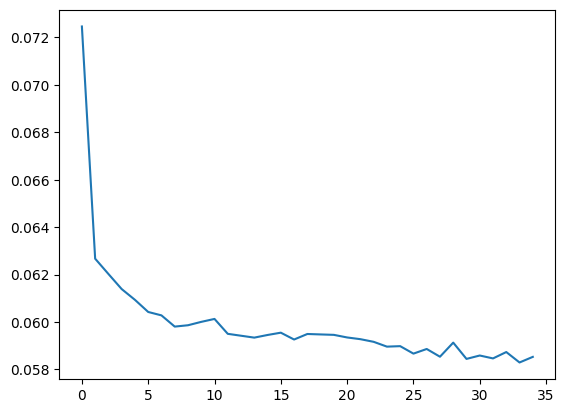

In [96]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

## Evaulate the test data

In [188]:
first_eval_batch = scaled_train[-n_input:]
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))
model.predict(first_eval_batch)

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))



1/1 [==============================] - 0s 27ms/step


In [189]:
current_batch.shape

(1, 7, 2)

In [136]:
np.append(current_batch[:,1:,:],[[[2,7]]],axis=1)

array([[[0.6       , 0.3       ],
        [0.16666667, 0.33333333],
        [0.5       , 0.36666667],
        [0.3       , 0.4       ],
        [0.16666667, 0.43333333],
        [0.13333333, 0.46666667],
        [2.        , 7.        ]]])

In [190]:
# go beyond len(test) to go into the unknown future (no way to measure success except wait!)
for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    current_batch = current_batch.reshape((1, n_input, n_features))
    
  

1/1 [==============================] - 0s 28ms/step


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 2, the array at index 0 has size 2 and the array at index 1 has size 1

## Inverse predictions and compare

In [182]:
test_predictions = test_predictions.reshape((n_input, n_features))


AttributeError: 'list' object has no attribute 'reshape'

In [177]:
true_predictions = scaler.inverse_transform(test_predictions[0:7])
test['Predictions'] = true_predictions

ValueError: Expected 2D array, got 1D array instead:
array=[ 0.39112076  0.80692822 -1.32272947 -2.35262966 -4.04297066 -6.15674019
 -9.41705894].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [111]:
test.head()

,daily_fraud,day
trans_date,,
2022-11-16,12,16
2022-11-17,8,17
2022-11-20,6,20
2022-11-21,6,21
2022-11-24,1,24


<Axes: xlabel='trans_date'>

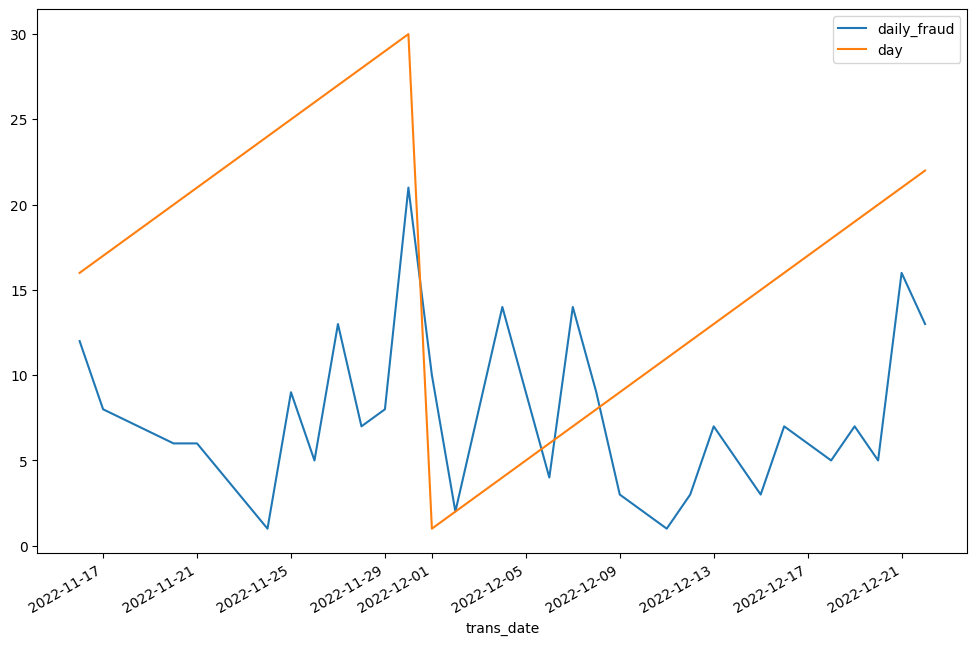

In [112]:
test.plot(figsize=(12,8))

In [1]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['daily_fraud'], test['Predictions']))
mse=mean_squared_error(test['daily_fraud'], test['Predictions'])
print(rmse)
print(mse)

NameError: name 'test' is not defined

Extra Variable: Day of the Week